## Importing Common Libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import torch 
import json
import sys
import torch
import torch.nn.functional as F
import os
import numpy as np

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_weights, load_model

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_test"

train_dataset = SongDataSet_Image(train_dir, num_classes=21, psuedo_labels_generated=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=21, psuedo_labels_generated=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

## UMAP as Input to Linear Probe

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


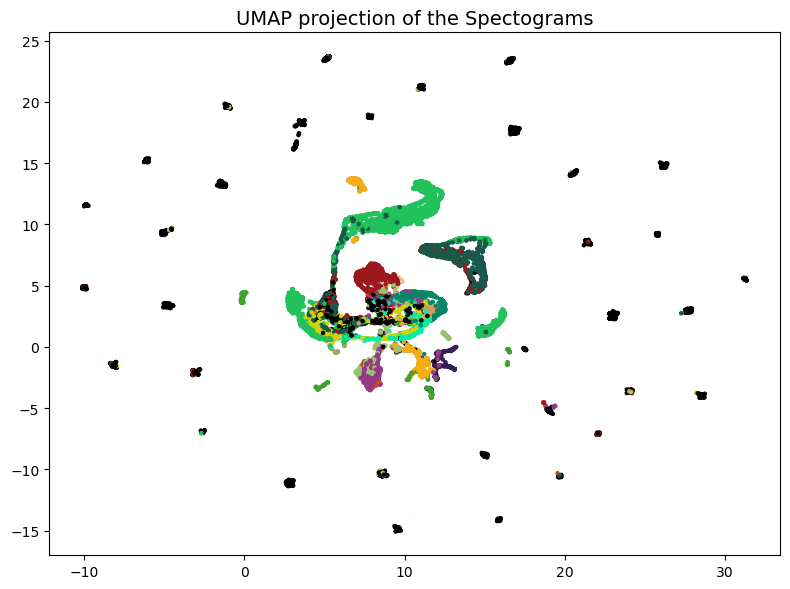

In [3]:
reductions_dims = 171

import pickle 
import umap

list_of_data = []
list_of_ground_truth = []

for i,  (data, ground_truth_label, _) in enumerate(train_loader):
    # remove channel dim (used for conv)
    data = data[:,0,:,:]
    data = data.permute(0,2,1)
    ground_truth_label = ground_truth_label.argmax(-1)
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    ground_truth_label = ground_truth_label.reshape(-1,1)
    data = data.reshape(-1,1 * 196)
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

    if i > 0:
        break

list_of_data = list_of_data[:1000]
list_of_ground_truth = list_of_ground_truth[:1000]


list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# color stuff #
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

colors_for_points = []
for label_row in list_of_ground_truth:
    if label_row.ndim > 0:
        # If label_row is iterable (more than one dimension)
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        # If label_row is a single integer (one dimension)
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)


reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.05, n_components=2, metric='euclidean')
embedding_outputs = reducer.fit_transform(list_of_data)

# Create the plot
fig = plt.figure(figsize=(8, 6))
plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
plt.title(f'UMAP projection of the Spectograms', fontsize=14)
plt.tight_layout()
plt.show()

In [4]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="umap", model=reducer, freeze_layers=True, layer_num=-1, layer_id="feed_forward_output_relu", classifier_dims=2)
classifier_model = classifier_model.to(device)


In [5]:

trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-2, plotting=True, batches_per_eval=100, desired_total_batches=2, patience=8)
trainer.train()

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

Evaluating: 100%|██████████| 133/133 [04:19<00:00,  1.95s/batch]


Total Frame Error Rate: 39.74%


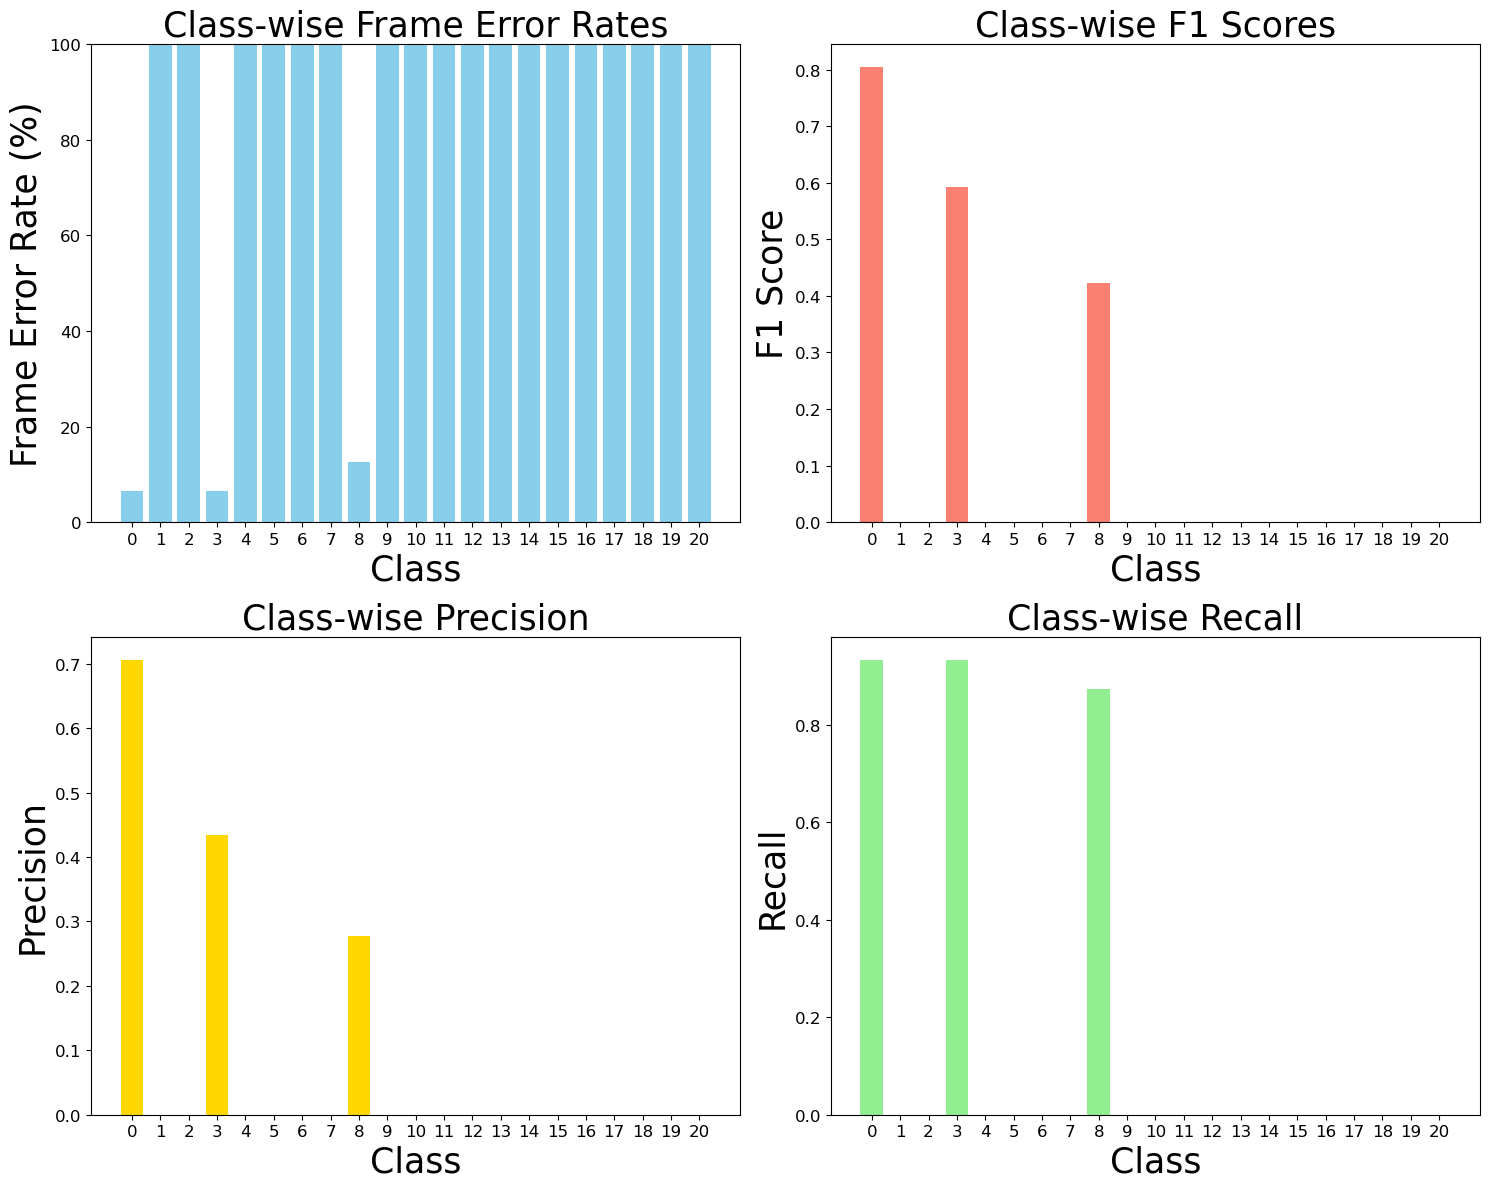

In [ ]:
import torch
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

num_classes = 21  # Update this if the number of classes changes

def validate_model_multiple_passes(model, test_loader, num_passes=1, max_batches=100):
    model.eval()
    # Initialize metrics
    errors_per_class = [0] * num_classes
    correct_per_class = [0] * num_classes
    tp_per_class = [0] * num_classes
    fp_per_class = [0] * num_classes
    fn_per_class = [0] * num_classes
    total_frames = 0
    total_errors = 0

    total_iterations = num_passes * min(max_batches, len(test_loader))
    progress_bar = tqdm(total=total_iterations, desc="Evaluating", unit="batch")

    for _ in range(num_passes):  # Outer loop for multiple passes
        with torch.no_grad():
            for i, (spectrogram, label) in enumerate(test_loader):
                if i >= max_batches:  # Early stopping condition for each pass
                    break
                label = label.to(device)

                spectrogram = spectrogram[:,0,:,:]
                spectrogram = spectrogram.permute(0,2,1)
                spectrogram = spectrogram.reshape(-1,1 * 513)
                label = label.reshape(-1,num_classes)

                spectrogram = reducer.transform(spectrogram)
                spectrogram = torch.Tensor(spectrogram)
                spectrogram = spectrogram.to(device)

                output = model.forward(spectrogram)

                predicted_labels = output.argmax(dim=-1)
                true_labels = label.argmax(dim=-1)

                correct = (predicted_labels == true_labels)
                incorrect = ~correct

                for cls in range(num_classes):  # Iterate over the number of classes
                    class_mask = (true_labels == cls)
                    predicted_class_mask = (predicted_labels == cls)

                    correct_class = correct & class_mask
                    incorrect_class = incorrect & class_mask

                    tp = correct_class.sum().item()
                    fp = (predicted_class_mask & ~class_mask).sum().item()
                    fn = (class_mask & ~predicted_class_mask).sum().item()

                    tp_per_class[cls] += tp
                    fp_per_class[cls] += fp
                    fn_per_class[cls] += fn

                    correct_per_class[cls] += tp
                    errors_per_class[cls] += incorrect_class.sum().item()

                    total_frames += tp + incorrect_class.sum().item()
                    total_errors += incorrect_class.sum().item()

                progress_bar.update(1)  # Update progress bar after each batch

    progress_bar.close()  # Close the progress bar
    # Calculate Precision, Recall, and F1 score per class
    precision_per_class = {}
    recall_per_class = {}
    f1_scores_per_class = {}
    for cls in range(num_classes):
        precision = tp_per_class[cls] / (tp_per_class[cls] + fp_per_class[cls]) if tp_per_class[cls] + fp_per_class[cls] > 0 else 0
        recall = tp_per_class[cls] / (tp_per_class[cls] + fn_per_class[cls]) if tp_per_class[cls] + fn_per_class[cls] > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        precision_per_class[cls] = precision
        recall_per_class[cls] = recall
        f1_scores_per_class[cls] = f1_score

    # Calculate frame error rates, handling division by zero
    class_frame_error_rates = {
        cls: (errors / (errors + correct) * 100 if errors + correct > 0 else float('nan'))
        for cls, (errors, correct) in enumerate(zip(errors_per_class, correct_per_class))
    }

    total_frame_error_rate = (total_errors / total_frames * 100 if total_frames > 0 else float('nan'))
    print(f'Total Frame Error Rate: {total_frame_error_rate:.2f}%')

    class_occurrences = [(correct + errors) / total_frames * 100 for correct, errors in zip(correct_per_class, errors_per_class)]

    return class_frame_error_rates, class_occurrences, f1_scores_per_class, precision_per_class, recall_per_class

# Assuming model and test_loader have been defined and initialized correctly
class_frame_error_rates, class_occurrences, f1_scores_per_class, precision_per_class, recall_per_class = validate_model_multiple_passes(model, test_loader, num_passes=1, max_batches=1250)

# Plotting the class-wise frame error rates, F1 scores, Precision and Recall
classes = list(range(num_classes))
error_rates = [class_frame_error_rates.get(cls, float('nan')) for cls in classes]
f1_scores = [f1_scores_per_class.get(cls, float('nan')) for cls in classes]
precisions = [precision_per_class.get(cls, float('nan')) for cls in classes]
recalls = [recall_per_class.get(cls, float('nan')) for cls in classes]

plt.figure(figsize=(15, 12))

# Subplot 1: Error Rates
plt.subplot(2, 2, 1)
plt.bar(classes, error_rates, color='skyblue')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Frame Error Rate (%)', fontsize=25)
plt.title('Class-wise Frame Error Rates', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)

# Subplot 2: F1 Scores
plt.subplot(2, 2, 2)
plt.bar(classes, f1_scores, color='salmon')
plt.xlabel('Class', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.title('Class-wise F1 Scores', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

# Subplot 3: Precision
plt.subplot(2, 2, 3)
plt.bar(classes, precisions, color='gold')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Precision', fontsize=25)
plt.title('Class-wise Precision', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

# Subplot 4: Recall
plt.subplot(2, 2, 4)
plt.bar(classes, recalls, color='lightgreen')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Recall', fontsize=25)
plt.title('Class-wise Recall', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()